In [1]:
#True positive: class correct, confidence/IoU above threshold
#False positive: class correct, confidence/IoU below threshold
#True negative: 
#False negative: class incorrect or no detection

#precision : TP / TP + FP (all detections) - 

#recall : TP / TP + FN (all ground truths) - 90 grouth truths per validation set
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

class APCalculator():
    
    
    def getAP(self, iou_thresh, plot=False):
        recall, precision = self.getRecallPrecision(iou_thresh)
        max_precision = []
        ap = 0
        for i in range(0, len(recall)):
            cur_recall = recall[i]
            #get maximum precision to the right of current recall
            cur_max_precision = max(precision)
            precision.pop(0)
            max_precision.append(cur_max_precision)
            
        max_precision.append(0)
        recall.append(max(recall))
        
        prev_recall = 0
        cur_max_precision = max(max_precision)
        for i in range(0, len(recall)):
            if(max_precision[i] < cur_max_precision):
                ap = ap + ((recall[i-1] - prev_recall) * cur_max_precision)
                prev_recall = recall[i-1]
                cur_max_precision = max_precision[i]
                
        if plot: 
            plt.plot(recall, max_precision)
            axes = plt.gca()
            axes.set_xlim([0,1.1])
            axes.set_ylim([0,1.1])
    
        return ap
    
    def plotPrecisionRecall(self, iou_thresh):
        recall, precision = self.getRecallPrecision(iou_thresh)
        plt.plot(recall, precision)
        axes = plt.gca()
        axes.set_xlim([0,1.1])
        axes.set_ylim([0,1.1])
        axes.set_ylabel('Precision')
        axes.set_xlabel('Recall')
        axes.set_title('{0} at IoU {1}'.format(os.path.basename(self.results_file), iou_thresh))

        
    def getRecallPrecision(self, iou_thresh):
        #iterate thru detections in descending confidence order, accumulate TP and FP
        acc_TP = 0
        acc_FP = 0
        
        recall = []
        precision = []
        
        for index, row in self.scores_df.iterrows():
            cur_confidence = row['confidence']
            cur_iou = row['iou']
            if cur_iou >= iou_thresh:
                #true positive
                acc_TP = acc_TP + 1
            else:
                #false positive
                acc_FP = acc_FP + 1
            #calculate current precision and recall
            cur_recall = acc_TP / self.gt_count
            cur_precision = acc_TP / (acc_TP + acc_FP)
            
            recall.append(cur_recall)
            precision.append(cur_precision)
    
        return recall, precision
    
    def __init__(self, results_file, num_ground_truths):
        self.results_file = results_file
        self.gt_count = num_ground_truths
        #self.scores_df = pd.DataFrame(columns=['confidence','iou','det_class','gt_class'], dtype=np.float)
        #read results file
        scores_list = []
        with open(self.results_file, 'r') as r_file:
            line = r_file.readline()
            while line != '':
                scores = line.split(',')
                confidence = float(scores[0].split(':')[1])
                iou = float(scores[1].split(':')[1])
                det_class = int(scores[2].split(':')[1])
                gt_class = int(scores[3].split(':')[1])
                #remove detections that have incorrect class
                if(det_class == gt_class):
                    scores_list.append([confidence, iou])                
                #print('{0}, {1}, {2}, {3}'.format(confidence, iou, det_class, gt_class))
                line = r_file.readline()
        self.scores_df = pd.DataFrame(data=scores_list, columns=['confidence','iou'], dtype=np.float).sort_values(by='confidence', ascending=False)
        


0.7013526793058108

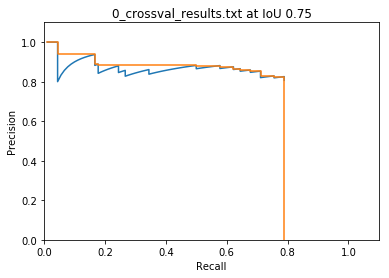

In [2]:
results_file = '/home/idies/workspace/paradim_data/models/stepsPerEpoch/100/0_crossval_results.txt'
ap_calc = APCalculator(results_file, num_ground_truths = 90)
ap_calc.plotPrecisionRecall(iou_thresh=.75)
ap_calc.getAP(iou_thresh=.75, plot=True)
#recall, precision = ap_calc.getRecallPrecision(iou_thresh=.5)

In [3]:
def calcAPavg(steps_root, iou_thresholds, ground_truth_count):
    #ret_steps = os.listdir(steps_root)
    ret_steps = ['10', '25', '50', '75', '100', '200', '500']
    ret_aps = []
    for steps in ret_steps: #formerly os.listdir(steps_root)
        grand_avg_ap = 0
        for iou_threshold in iou_thresholds:
            results_files = []
            for files in os.listdir(os.path.join(steps_root, steps)):
                if 'results.txt' in files:
                    results_files.append(os.path.join(steps_root, steps, files))
            cross_val_count = 0
            avg_ap = 0
            for result_file in results_files:
                ap_calc = APCalculator(result_file, num_ground_truths=ground_truth_count)
                avg_ap = avg_ap + ap_calc.getAP(iou_thresh=iou_threshold)
                cross_val_count = cross_val_count + 1
            avg_ap = avg_ap / cross_val_count
            grand_avg_ap = grand_avg_ap + avg_ap
        grand_avg_ap = grand_avg_ap / len(iou_thresholds)
        ret_aps.append(grand_avg_ap)
        #print("step count: {0}, AP: {1}".format(steps, grand_avg_ap))
    return ret_steps, ret_aps

In [4]:
steps_root = '/home/idies/workspace/paradim_data/models/stepsPerEpoch'
iou_thresholds = [.5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
#iou_thresholds = [.5]
ground_truth_count = 90 #max possible detections

steps, apAll = calcAPavg(steps_root, iou_thresholds, ground_truth_count)
iou_thresholds = [.5]
steps, ap50 = calcAPavg(steps_root, iou_thresholds, ground_truth_count)
iou_thresholds = [.75]
steps, ap75 = calcAPavg(steps_root, iou_thresholds, ground_truth_count)



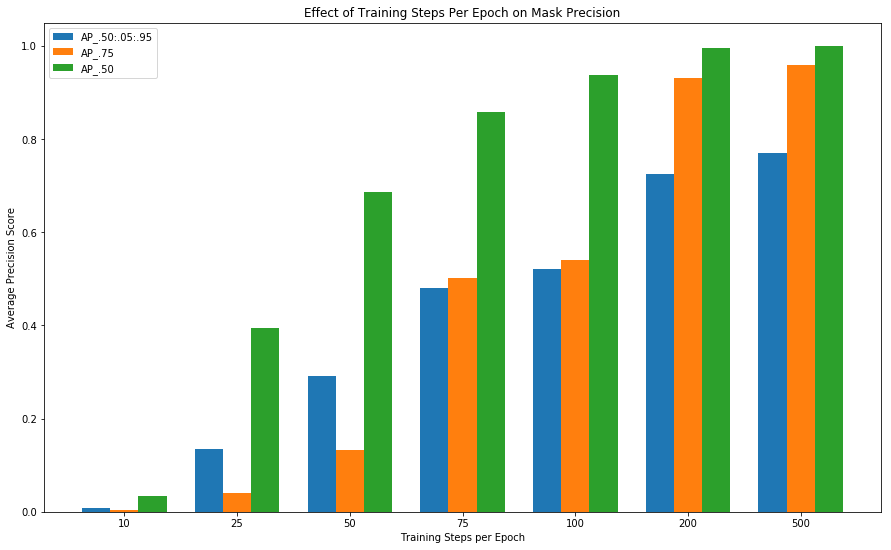

In [6]:
labels = steps
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, apAll, width, label='AP_.50:.05:.95')
rects2 = ax.bar(x, ap75, width, label='AP_.75')
rects3 = ax.bar(x + width, ap50, width, label='AP_.50')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Precision Score')
ax.set_xlabel('Training Steps per Epoch')
ax.set_title('Effect of Training Steps Per Epoch on Mask Precision')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)

#fig.tight_layout() # not sure what this does

fig.set_size_inches(15, 9) #set figure size in inches 

fig.savefig('TrainingStepsVsAP.png', dpi=250) #uncomment to save the fig as png

plt.show()